<a href="https://colab.research.google.com/github/sandeep4055/pytorch_practise/blob/main/Pytorch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  PyTorch Neural Network Classification

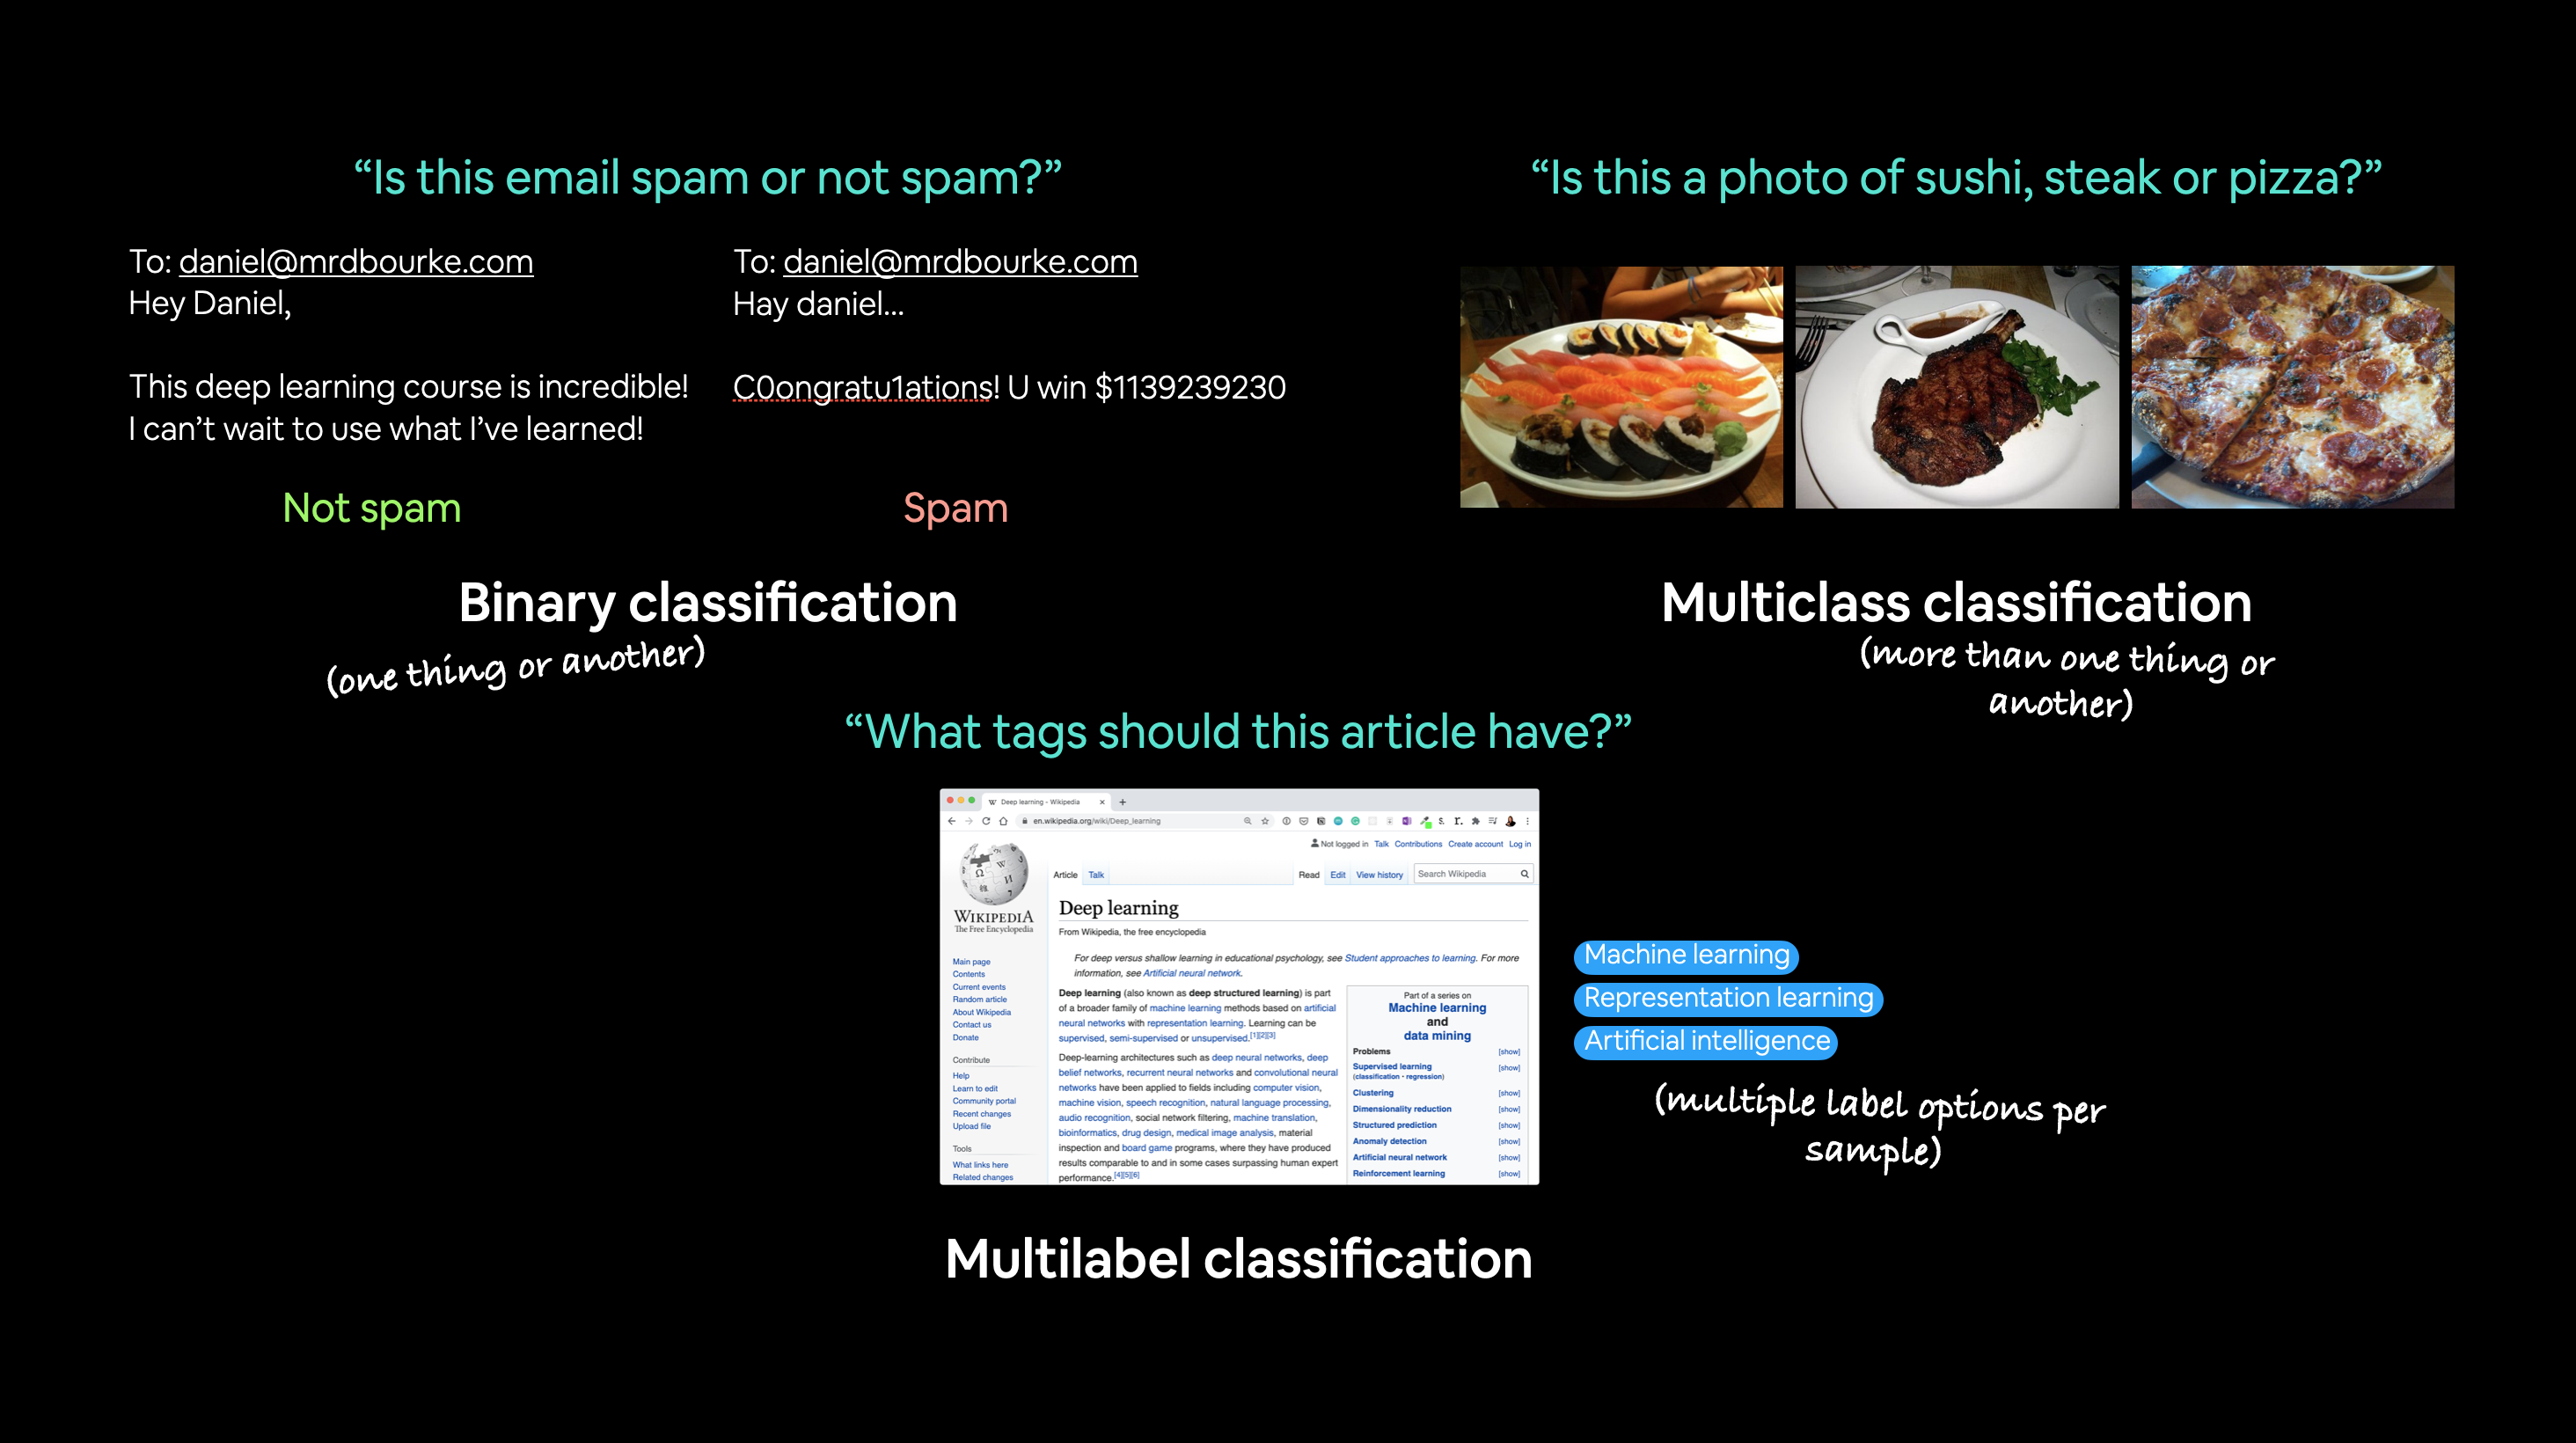

# 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

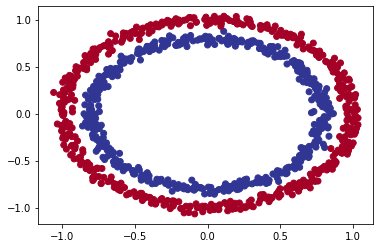

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Building a model

In [9]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.8334],
        [-0.7596],
        [-0.9018],
        [-0.8145],
        [-0.7032],
        [-0.6597],
        [-0.6093],
        [-0.5854],
        [-0.9100],
        [-0.7524]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

In [15]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.8334],
        [-0.7596],
        [-0.9018],
        [-0.8145],
        [-0.7032]], grad_fn=<SliceBackward0>)

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3029],
        [0.3187],
        [0.2887],
        [0.3069],
        [0.3311]], grad_fn=<SigmoidBackward0>)

In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [18]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.76671, Accuracy: 50.00% | Test loss: 0.76104, Test acc: 50.00%
Epoch: 10 | Loss: 0.71749, Accuracy: 50.00% | Test loss: 0.71644, Test acc: 50.00%
Epoch: 20 | Loss: 0.70119, Accuracy: 50.00% | Test loss: 0.70153, Test acc: 50.00%
Epoch: 30 | Loss: 0.69575, Accuracy: 50.00% | Test loss: 0.69650, Test acc: 50.00%
Epoch: 40 | Loss: 0.69394, Accuracy: 50.00% | Test loss: 0.69480, Test acc: 50.00%
Epoch: 50 | Loss: 0.69333, Accuracy: 50.00% | Test loss: 0.69423, Test acc: 50.00%
Epoch: 60 | Loss: 0.69313, Accuracy: 41.62% | Test loss: 0.69404, Test acc: 38.50%
Epoch: 70 | Loss: 0.69306, Accuracy: 48.12% | Test loss: 0.69399, Test acc: 47.00%
Epoch: 80 | Loss: 0.69303, Accuracy: 49.38% | Test loss: 0.69398, Test acc: 45.50%
Epoch: 90 | Loss: 0.69302, Accuracy: 49.88% | Test loss: 0.69400, Test acc: 47.00%


Hmm, what do you notice about the performance of our model?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

# 4. Improving a model (from a model perspective)

In [20]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [22]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


The missing piece: non-linearity

In [24]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [25]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [26]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [27]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

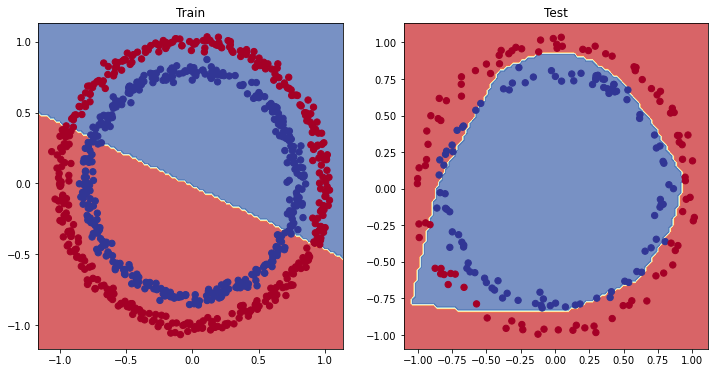

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

# Putting things together by building a multi-class PyTorch mode

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


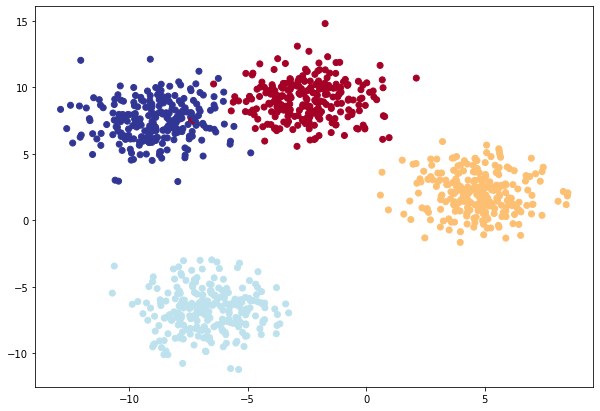

In [30]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [31]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [33]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [34]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [35]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [36]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [37]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [38]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


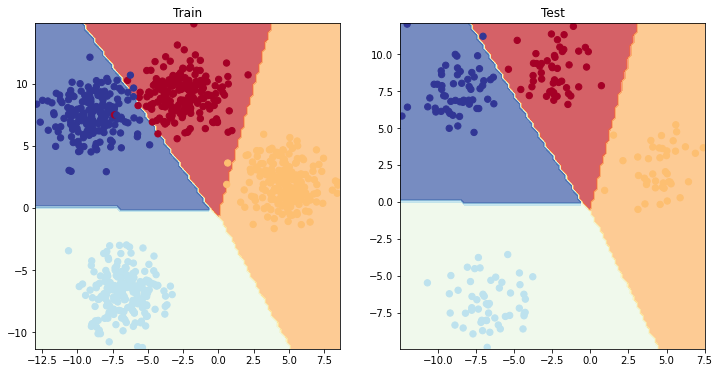

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [40]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 8.6 MB/s eta 0:00:00


tensor(0.9950)